# Analysing AAPL options

In [1]:
#Import required libraries
import torch
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tqdm as notebook_tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import torch.nn.functional as F

In [2]:
# Choose the device for computation
device = torch.device('cpu')

## Data Preprocessing

In [3]:
# Methods to calculate the Black-Scholes option prices

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes call option price.

    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying stock

    Returns:
    float: Call option price
    """
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    
    N_d1 = 0.5 * (1 + torch.erf(d1 / math.sqrt(2)))
    N_d2 = 0.5 * (1 + torch.erf(d2 / math.sqrt(2)))
    
    call_price = S * N_d1 - K * torch.exp(-r * T) * N_d2
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes put option price.

    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying stock

    Returns:
    float: Put option price
    """
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    
    N_d1 = 0.5 * (1 + torch.erf(-d1 / math.sqrt(2)))
    N_d2 = 0.5 * (1 + torch.erf(-d2 / math.sqrt(2)))
    
    put_price = K * torch.exp(-r * T) * N_d2 - S * N_d1
    return put_price


In [4]:
options_data = pd.read_csv('jnnksdxiidjlejyn.csv')
stock_prices_data = pd.read_csv('stock_prices_aapl_2022.csv')

In [5]:
options_data.tail()

,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,ticker,index_flag,issuer,exercise_style
231740,2022-12-30,2025-01-17,2022-12-30,C,75000,62.25,66.15,15,0.401064,0.909907,0.001996,27.71559,-5.322647,149531728,100,AAPL,0,APPLE INC,A
231741,2022-12-30,2025-01-17,2022-12-30,C,80000,59.45,60.90,30,0.385271,0.896819,0.002323,31.02641,-5.635316,149531729,100,AAPL,0,APPLE INC,A
231742,2022-12-30,2025-01-17,2022-12-30,C,85000,54.85,58.80,5,0.387946,0.876305,0.002663,35.75625,-6.140437,149531730,100,AAPL,0,APPLE INC,A
231743,2022-12-30,2025-01-17,2022-12-30,C,90000,52.00,54.75,17,0.383652,0.856602,0.003009,40.01353,-6.538813,149531731,100,AAPL,0,APPLE INC,A
231744,2022-12-30,2025-01-17,2022-12-30,C,95000,48.60,51.45,22,0.378899,0.835674,0.003359,44.08449,-6.901461,149531732,100,AAPL,0,APPLE INC,A


In [6]:
options_data.describe()

,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,index_flag
count,231745.000000,231745.000000,231745.000000,231745.000000,211076.000000,211076.000000,211076.000000,211076.000000,211076.000000,2.317450e+05,231745.0,231745.0
mean,159060.633455,27.675167,28.076322,777.266590,0.458185,0.482070,0.006758,19.235582,-12.865614,1.442466e+08,100.0,0.0
std,64087.229135,33.455194,33.752894,5820.564791,0.283766,0.392335,0.009867,22.076527,21.631369,5.008530e+06,0.0,0.0
min,25000.000000,0.000000,0.010000,0.000000,0.151039,0.000619,0.000000,0.000223,-734.326500,1.305090e+08,100.0,0.0
25%,110000.000000,0.510000,0.590000,0.000000,0.310949,0.043089,0.001004,1.963998,-13.742892,1.414705e+08,100.0,0.0
50%,150000.000000,12.300000,12.650000,8.000000,0.371723,0.486595,0.003625,10.330390,-7.651854,1.447367e+08,100.0,0.0
75%,205000.000000,47.550000,48.250000,109.000000,0.484269,0.903945,0.008010,30.046845,-3.247278,1.481613e+08,100.0,0.0
max,320000.000000,156.700000,157.050000,365875.000000,2.998775,0.999998,0.184287,105.490200,-0.098726,1.517594e+08,100.0,0.0


Definition of the data:

1. [Strike Price](https://www.investopedia.com/terms/s/strikeprice.asp)
2. [Implied Volatility](https://www.investopedia.com/terms/i/iv.asp)
3. [Options Greeks](https://www.investopedia.com/trading/getting-to-know-the-greeks/#toc-delta)
4. [Forward Price](https://www.investopedia.com/terms/f/forwardprice.asp)

In [7]:
stock_prices_data.tail()

,Date,Open,High,Low,Close,Volume
246,01/07/2022,172.89,174.14,171.03,172.17,"86,709,148"
247,01/06/2022,172.70,175.30,171.64,172.00,"96,903,961"
248,01/05/2022,179.61,180.17,174.64,174.92,"94,537,602"
249,01/04/2022,182.63,182.94,179.12,179.70,"99,310,438"
250,01/03/2022,177.83,182.88,177.71,182.01,"104,701,203"


In [8]:
options_data['date'] = pd.to_datetime(options_data['date'])
stock_prices_data['Date'] = pd.to_datetime(stock_prices_data['Date'])

# Merge options and stock prices data based on date
merged_data = options_data.merge(stock_prices_data, left_on='date', right_on='Date', how="inner")

# Calculate time to expiration in years
merged_data['exdate'] = pd.to_datetime(merged_data['exdate'])
merged_data['time_to_expiration'] = (merged_data['exdate'] - merged_data['date']).dt.total_seconds() / (24 * 60 * 60 * 365)

columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Volume', 'date', 'exdate', 'volume', 'delta', 'gamma', 'vega', 'theta', 'optionid', 'ticker', 'index_flag', 'issuer', 'exercise_style']
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data = merged_data.dropna()

# Filter call options
call_options_data = merged_data[merged_data['cp_flag'] == "C"]
call_options_data.drop(columns='cp_flag', inplace=True)

call_options_data = call_options_data.reset_index()

print("Processed Data Summary:")
call_options_data.head()

Processed Data Summary:


,index,last_date,strike_price,best_bid,best_offer,impl_volatility,contract_size,Close,time_to_expiration
0,18,2022-01-03,152500,28.25,31.25,0.937468,100,182.01,0.010959
1,20,2022-01-03,157500,24.20,24.95,0.630916,100,182.01,0.010959
2,22,2022-01-03,162500,19.30,20.65,0.753108,100,182.01,0.010959
3,26,2022-01-03,172500,9.40,9.65,0.196803,100,182.01,0.010959
4,27,2022-01-03,175000,7.10,7.20,0.247537,100,182.01,0.010959


In [9]:
train_call_options_data, test_call_options_data = train_test_split(call_options_data, test_size=0.1, random_state=42)

In [10]:
train_call_options_data = train_call_options_data.reset_index(drop=True)
test_call_options_data = test_call_options_data.reset_index(drop=True)

In [11]:
train_call_options_data

,index,last_date,strike_price,best_bid,best_offer,impl_volatility,contract_size,Close,time_to_expiration
0,165865,2022-09-15,230000,0.00,0.01,0.509241,100,151.76,0.065753
1,2155,2022-01-05,90000,85.10,85.50,0.655313,100,174.92,0.271233
2,96063,2022-06-07,225000,0.17,0.19,0.308644,100,148.71,0.372603
3,16559,2022-01-27,230000,3.10,3.30,0.307012,100,159.22,0.980822
4,121037,2022-07-19,240000,1.81,2.05,0.281845,100,151.00,1.158904
...,...,...,...,...,...,...,...,...,...
181351,138959,2022-08-16,180000,0.02,0.03,0.211350,100,173.03,0.008219
181352,118753,2022-07-15,146000,8.10,8.25,0.357417,100,150.17,0.076712
181353,153196,2022-09-07,100000,59.25,59.55,0.443723,100,155.96,0.619178
181354,169655,2022-10-03,149000,4.35,4.45,0.374358,100,142.45,0.106849


## Defining and training the PINN model

In [12]:
# Extract data for Black-Scholes calculation
K = torch.tensor(train_call_options_data.strike_price.values / 1000)  # Strike prices
sigma = torch.tensor(0.2)
S = torch.tensor(train_call_options_data.Close.values)  # Closing stock prices
T = torch.tensor(train_call_options_data.time_to_expiration.values)  # Time to expiration in years
r = torch.tensor(0.04)  # Risk-free interest rate


call_price = torch.tensor(train_call_options_data.best_offer)

In [13]:
# Define the deep neural network (DNN) class
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.depth = len(layers) - 1
        
        self.activation = torch.nn.ReLU
        
        # Create a list to hold layers and activation functions
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        # Append the last linear layer (output layer)
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        # Forward pass through the network
        out = self.layers(x)
        return out

In [14]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, S, t, sigma, u, layers, r, batch_size=64, shuffle=True):
        # Store data and parameters
        self.S = torch.tensor(S, requires_grad=True).float().to(device)
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.r = r
        self.sigma = sigma
        self.batch_size = batch_size

        # Create a custom dataset
        self.dataset = TensorDataset(self.S, self.t, self.u)
        
        # Create a data loader for batch sampling
        self.data_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=shuffle)        
        
        # Create the deep neural network
        self.dnn = DNN(layers).to(device)
        
        # Initialize optimizer
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.0001, weight_decay=1e-5)
        self.iter = 0
        
        self.initialize_weights
        
        
    def initialize_weights(self, initialization_method=init.xavier_normal_):
        """
        Initialize weights of a neural network using the specified initialization method.

        Args:
            net (nn.Module): The neural network.
            initialization_method: The initialization method from torch.nn.init.
        """
        for m in self.dnn.modules():
            if isinstance(m, (torch.nn.Linear)):
                initialization_method(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    
    def net_u(self, S, t):  
        u = self.dnn(torch.cat([S, t], dim=1))
        return u
    
    def net_f(self, S, t):
        """ The pytorch autograd version of calculating residual """
        sigma = self.sigma       
        r = self.r
        u = self.net_u(S, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_s = torch.autograd.grad(
            u, S, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_ss = torch.autograd.grad(
            u_s, S, 
            grad_outputs=torch.ones_like(u_s),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t + 0.5 * sigma**2 * S**2 * u_ss + r * S * u_s - r * u
        return f
    
    def loss_func(self, S_batch, t_batch, u_batch):
        u_pred = self.net_u(S_batch, t_batch)
        f_pred = self.net_f(S_batch, t_batch)
        loss = F.mse_loss(u_batch,u_pred) + torch.mean(f_pred ** 2)
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            for batch_index, (S_batch, t_batch, u_batch) in enumerate(self.data_loader):
                loss = self.loss_func(S_batch, t_batch, u_batch)
                
                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if batch_index % 10 == 0:
                    print('Epoch: %d, Batch: %d, Loss: %f' % (epoch, batch_index, loss.item()))
    
    def predict(self, S, t):
        S = torch.tensor(S, requires_grad=True).float().to(device)
        t = torch.tensor(t, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(S, t)
        f = self.net_f(S, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [15]:
# layers = [2] + list(reversed([2**x for x in [10 for x in range(10)]])) + [1]
layers = [2] + [128 for _ in range(20)] + [1]


batch_size = 4096
model = PhysicsInformedNN(S.unsqueeze(1), T.unsqueeze(1), sigma, call_price, layers, r, batch_size)

In [17]:
model.train(10)

Epoch: 0, Batch: 0, Loss: 946.492004
Epoch: 0, Batch: 10, Loss: 926.580627
Epoch: 0, Batch: 20, Loss: 942.357056
Epoch: 0, Batch: 30, Loss: 951.072144
Epoch: 0, Batch: 40, Loss: 951.300415
Epoch: 0, Batch: 50, Loss: 980.690857
Epoch: 0, Batch: 60, Loss: 892.628784
Epoch: 0, Batch: 70, Loss: 934.679321
Epoch: 0, Batch: 80, Loss: 983.269714
Epoch: 1, Batch: 0, Loss: 951.718933
Epoch: 1, Batch: 10, Loss: 969.297546
Epoch: 1, Batch: 20, Loss: 950.270874
Epoch: 1, Batch: 30, Loss: 985.009705
Epoch: 1, Batch: 40, Loss: 1003.265564
Epoch: 1, Batch: 50, Loss: 966.200195
Epoch: 1, Batch: 60, Loss: 952.090271
Epoch: 1, Batch: 70, Loss: 962.157654
Epoch: 1, Batch: 80, Loss: 997.166382
Epoch: 2, Batch: 0, Loss: 928.564331
Epoch: 2, Batch: 10, Loss: 1039.667114
Epoch: 2, Batch: 20, Loss: 1005.359375
Epoch: 2, Batch: 30, Loss: 966.661621
Epoch: 2, Batch: 40, Loss: 956.769714
Epoch: 2, Batch: 50, Loss: 960.673279
Epoch: 2, Batch: 60, Loss: 949.949463
Epoch: 2, Batch: 70, Loss: 938.625671
Epoch: 2, Ba

In [17]:
S = torch.tensor(test_call_options_data.Close.values)  # Strike prices
T = torch.tensor(test_call_options_data.time_to_expiration.values)  # Time to expiration in years

call_price = torch.tensor(test_call_options_data.best_bid)

output, f = model.predict(S.unsqueeze(1), T.unsqueeze(1))

diff = torch.tensor(output).flatten() - call_price

S_numpy = S.numpy()
T_numpy = T.numpy()
diff_numpy = diff.numpy()

In [18]:
mse_loss = F.mse_loss(torch.tensor(output).flatten(), call_price)
print("MSE Loss:", mse_loss.item())

MSE Loss: 925.4713841321798


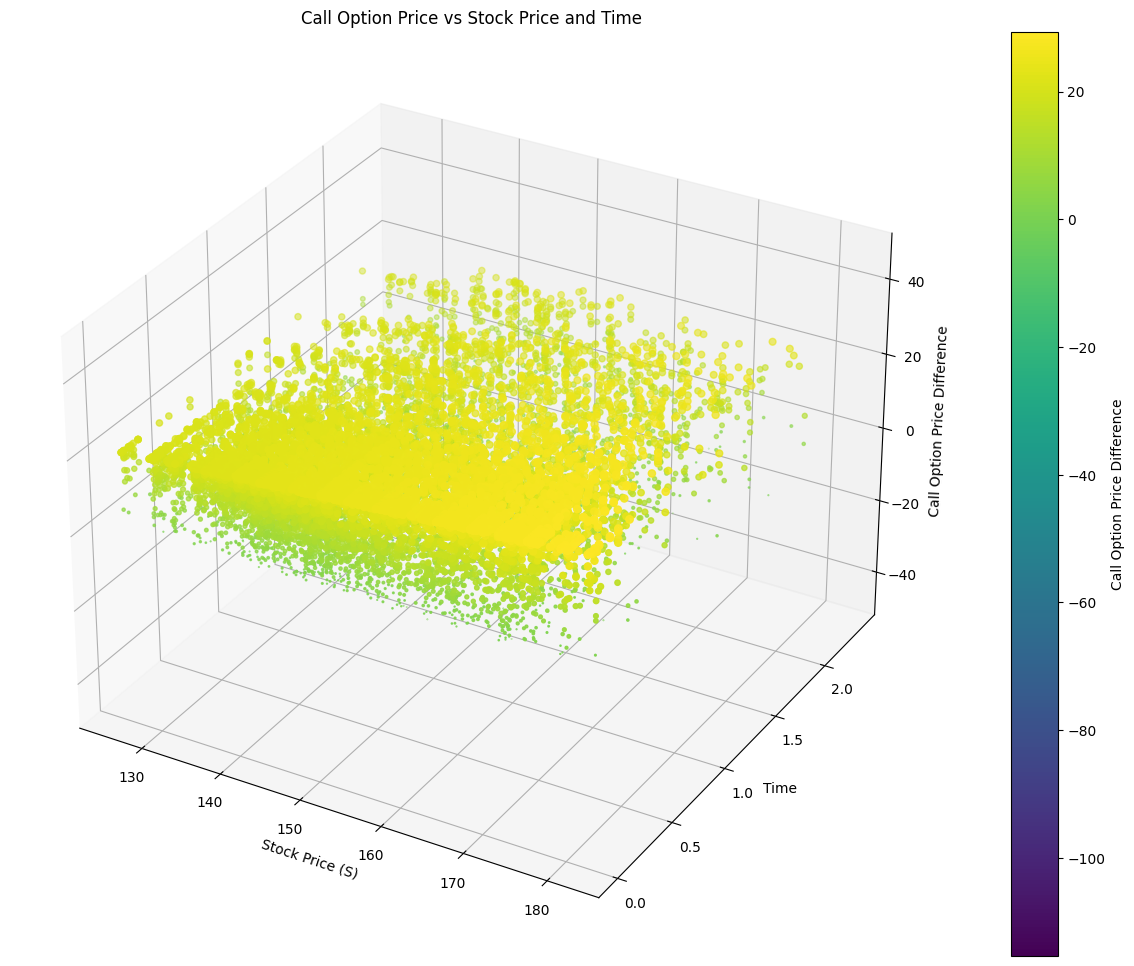

In [19]:
# Create a scatter plot with 3D-like appearance
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with output values as marker size
scatter = ax.scatter(S_numpy, T_numpy, diff_numpy, c=diff_numpy, cmap='viridis', s=diff_numpy)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Call Option Price Difference')

# Set plot labels and title
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time')
ax.set_zlabel('Call Option Price Difference')
ax.set_title('Call Option Price vs Stock Price and Time')

ax.set_zlim(-50,50)

plt.show()

In [20]:
# # Create a grid of points for the surface plot
# S_grid, T_grid = np.meshgrid(np.linspace(min(S_numpy), max(S_numpy), 100),
#                                np.linspace(min(T_numpy), max(T_numpy), 100))

# # Interpolate the output values using griddata
# output_grid = griddata((S_numpy, T_numpy), diff_numpy, (S_grid, T_grid), method='cubic', fill_value=0)

# # Create the surface plot
# fig = plt.figure(figsize=(20, 12))
# ax = fig.add_subplot(111, projection='3d')
# surface = ax.contourf(S_grid, T_grid, output_grid, cmap='viridis')

# # Add colorbar
# cbar = fig.colorbar(surface)
# cbar.set_label('Output Value')

# # Set plot labels and title
# ax.set_xlabel('Stock Price (S)')
# ax.set_ylabel('Time')
# ax.set_zlabel('Call Option Price Difference')
# ax.set_title('Call Option Price vs Stock Price and Time')


# plt.show()